# Your Title Here

**Name(s)**: (your name(s) here)

**Website Link**: (your website link)

## Code

In [1]:
import pandas as pd
import numpy as np
import os
import folium
import requests
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

import plotly.express as px
pd.options.plotting.backend = 'plotly'

### Cleaning and EDA

In [2]:
df = pd.read_excel('outage.xlsx', header=5)
df = df.drop([0]).drop(columns='variables').set_index('OBS')
df.columns

Index(['YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'NERC.REGION',
       'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CLIMATE.CATEGORY',
       'OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE',
       'OUTAGE.RESTORATION.TIME', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL',
       'HURRICANE.NAMES', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW',
       'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE', 'IND.PRICE',
       'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES',
       'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS',
       'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT',
       'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA',
       'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
       'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT',
       'PCT

In [3]:
df.groupby('CAUSE.CATEGORY').count()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
CAUSE.CATEGORY,,,,,,,,,,,,,,,,,,,,,
equipment failure,60,57,60,60,60,59,57,57,57,57,...,60,60,60,59,59,60,60,60,60,60
fuel supply emergency,51,50,51,51,51,51,50,50,50,50,...,51,51,51,51,51,51,51,51,51,51
intentional attack,418,418,418,418,418,418,418,418,418,418,...,418,418,418,418,418,418,418,418,418,418
islanding,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
public appeal,69,69,69,69,69,69,69,69,69,69,...,69,69,69,69,69,69,69,69,69,69
severe weather,763,759,763,763,763,759,759,759,759,759,...,763,763,763,754,754,763,763,763,763,763
system operability disruption,127,126,127,127,127,126,126,126,126,126,...,127,127,127,127,127,127,127,127,127,127


In [4]:
df.groupby('NERC.REGION').count()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
NERC.REGION,,,,,,,,,,,,,,,,,,,,,
ASCC,1,0,1,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
ECAR,34,34,34,34,34,34,34,34,34,32,...,34,34,34,34,34,34,34,34,34,34
FRCC,44,43,44,44,44,43,43,43,43,43,...,44,44,44,44,44,44,44,44,44,44
"FRCC, SERC",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HECO,3,3,3,3,0,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
HI,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
MRO,46,45,46,46,46,45,45,45,45,44,...,46,46,46,46,46,46,46,46,46,46
NPCC,150,150,150,150,150,150,150,150,150,147,...,150,150,150,150,150,150,150,150,150,150
PR,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [5]:
len(df['MONTH'].dropna())

1525

In [6]:
len(df['OUTAGE.START.TIME'].dropna())

1525

In [7]:
df_dropped = df.dropna(subset=['OUTAGE.START.TIME'])
df_dropped = df_dropped.dropna(subset=['OUTAGE.RESTORATION.TIME'])
temp = pd.to_timedelta(df_dropped['OUTAGE.START.TIME'].astype(str))
df_dropped['OUTAGE.START'] = df_dropped['OUTAGE.START.DATE'] + temp
temp = pd.to_timedelta(df_dropped['OUTAGE.RESTORATION.TIME'].astype(str))
df_dropped['OUTAGE.RESTORATION'] = df_dropped['OUTAGE.RESTORATION.DATE'] + temp
df_dropped['YEAR'] = df_dropped['YEAR'].astype(int)
df_dropped['MONTH'] = df_dropped['MONTH'].astype(int)
df_dropped.reset_index()

/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(
/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,1.0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2.0,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00
2,3.0,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
3,4.0,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00
4,5.0,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,1527.0,2016,3,Idaho,ID,WECC,Northwest,1.6,warm,2016-03-08 00:00:00,...,2216.8,2004.7,5.6,0.6,0.19,98.891934,1.108066,1.108066,2016-03-08 00:00:00,2016-03-08 00:00:00
1472,1529.0,2016,7,Idaho,ID,WECC,Northwest,-0.3,normal,2016-07-19 00:00:00,...,2216.8,2004.7,5.6,0.6,0.19,98.891934,1.108066,1.108066,2016-07-19 15:45:00,2016-07-19 19:25:00
1473,1530.0,2011,12,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06 00:00:00,...,2192.2,1868.2,3.9,0.27,0.1,97.599649,2.401765,2.401765,2011-12-06 08:00:00,2011-12-06 20:00:00
1474,1532.0,2009,8,South Dakota,SD,RFC,West North Central,0.5,warm,2009-08-29 00:00:00,...,2038.3,1905.4,4.7,0.3,0.15,98.307744,1.692256,1.692256,2009-08-29 22:54:00,2009-08-29 23:53:00


## Univariate Graphes

In [8]:
df_dropped.groupby(['CAUSE.CATEGORY','YEAR']).count()['MONTH'].unstack(level=0).plot(kind='bar')

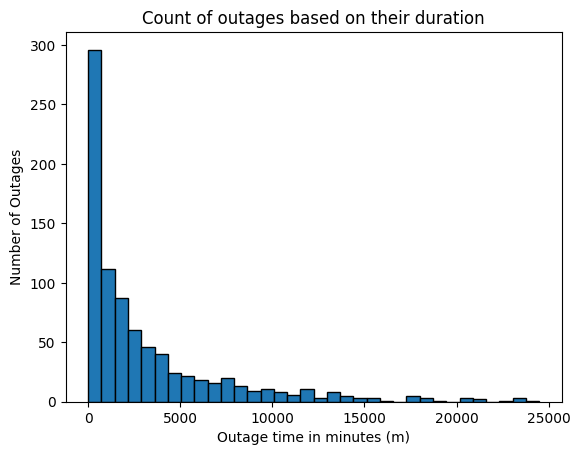

Each grouping represents 12 hour period, or half a day.


In [9]:
graph2 = df_dropped.groupby('OUTAGE.DURATION').count().reset_index()#['MONTH']#.plot(kind='hist')
w = 12*60
plt.hist(graph2['OUTAGE.DURATION'], bins=np.arange(min(graph2['OUTAGE.DURATION']), 25000, w), edgecolor='black', rwidth=500)
plt.xlabel('Outage time in minutes (m)')
plt.ylabel('Number of Outages')
plt.title('Count of outages based on their duration')
#plt.xticks([0, 1000, 2000, 4000, 6000, 8000, 10000, 100000])
plt.show()
print('Each grouping represents 12 hour period, or half a day.')

In [10]:
df_dropped.groupby('MONTH', dropna=True)['OUTAGE.DURATION'].mean().plot()

In [11]:
over_time_df = df_dropped.groupby(['OUTAGE.START'], dropna=True)['OUTAGE.DURATION'].count().plot()
# plt.plot(over_time_df)
# plt.show()
over_time_df

In [12]:
#df_dropped.groupby(['CAUSE.CATEGORY','CAUSE.CATEGORY.DETAIL']).count()


## Bivarate Graph

In [13]:
state_data = df_dropped[["U.S._STATE", "POSTAL.CODE", "OUTAGE.DURATION"]].groupby(['POSTAL.CODE','U.S._STATE']).mean()
state_data = state_data.reset_index()

state_geo = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
).json()
geo_merge = pd.DataFrame(state_geo['features'])
state_data = state_data.merge(geo_merge, left_on='POSTAL.CODE', right_on="id")

In [14]:
## GRAPHS/STATS I MADE BUT I DONT THINK ARE NEEDED NOW

#df_dropped.groupby(['U.S._STATE','OUTAGE.DURATION']).count().unstack(level=0)['MONTH'].plot(kind='bar')
#df_dropped.groupby('UTIL.CONTRI').count()
#df_dropped.groupby(['CAUSE.CATEGORY','CAUSE.CATEGORY.DETAIL']).count()

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["POSTAL.CODE", "OUTAGE.DURATION"],
    key_on="feature.id",
    #fill_color="YlGn",
    fill_opacity=0.9,
    line_opacity=0.2,
    bins=[0, 500, 1000, 2000, 4000, 6000, 8000],
    highlight=True,
    legend_name="Mean Duration of Outage per State",
    nan_fill_color="purple"
).add_to(m)
#m

In [15]:

### TRY TO ADD HIGHLIGHT FUNCTION THAT WORKS###

# style_function = lambda x: {'fillColor': '#ffffff', 
#                             'color':'#000000', 
#                             'fillOpacity': 0.1, 
#                             'weight': 0.1}
# highlight_function = lambda x: {'fillColor': '#000000', 
#                                 'color':'#000000', 
#                                 'fillOpacity': 0.50, 
#                                 'weight': 0.1}
# NIL = folium.features.GeoJson(
#     state_data,
#     style_function=style_function, 
#     control=False,
#     highlight_function=highlight_function, 
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=["POSTAL.CODE", "OUTAGE.DURATION"],
#         aliases=['STATE: ','Duration of Outage'],
#         style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
#     )
# )
# m.add_child(NIL)
# m.keep_in_front(NIL)
# folium.LayerControl().add_to(m)
# m

## Interesting AGG 

In [16]:
#df_dropped.groupby('MONTH', dropna=True).agg()
df_dropped.groupby(['OUTAGE.START'])['ANOMALY.LEVEL'].mean().plot(kind='scatter')

In [17]:
df_dropped.groupby(['ANOMALY.LEVEL']).count()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
ANOMALY.LEVEL,,,,,,,,,,,,,,,,,,,,,
-1.6,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
-1.5,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
-1.4,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
-1.3,35,35,35,35,35,35,35,35,35,35,...,35,34,34,35,35,35,35,35,35,35
-1.2,13,13,13,13,13,13,13,13,13,13,...,13,11,11,13,13,13,13,13,13,13
-1.1,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
-1.0,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
-0.9,54,54,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
-0.8,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20


In [18]:
df_cause = df_dropped[['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL']]
df_cause = pd.get_dummies(df_cause, columns=['CAUSE.CATEGORY.DETAIL'], dummy_na=True, prefix='CAUSE.CATEGORY.DETAIL')
df_cause.groupby('CAUSE.CATEGORY').agg('sum').plot(kind='bar')
#df_cause

In [19]:
df_cause.reset_index().drop(columns='OBS')#.sum(axis=0)

,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL_ Coal,CAUSE.CATEGORY.DETAIL_ Hydro,CAUSE.CATEGORY.DETAIL_ Natural Gas,CAUSE.CATEGORY.DETAIL_100 MW loadshed,CAUSE.CATEGORY.DETAIL_Coal,CAUSE.CATEGORY.DETAIL_HVSubstation interruption,CAUSE.CATEGORY.DETAIL_Hydro,CAUSE.CATEGORY.DETAIL_Petroleum,CAUSE.CATEGORY.DETAIL_breaker trip,...,CAUSE.CATEGORY.DETAIL_uncontrolled loss,CAUSE.CATEGORY.DETAIL_vandalism,CAUSE.CATEGORY.DETAIL_voltage reduction,CAUSE.CATEGORY.DETAIL_wildfire,CAUSE.CATEGORY.DETAIL_wind,CAUSE.CATEGORY.DETAIL_wind storm,CAUSE.CATEGORY.DETAIL_wind/rain,CAUSE.CATEGORY.DETAIL_winter,CAUSE.CATEGORY.DETAIL_winter storm,CAUSE.CATEGORY.DETAIL_nan
0,severe weather,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,intentional attack,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,severe weather,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,severe weather,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,severe weather,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,intentional attack,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1472,system operability disruption,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1473,public appeal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1474,islanding,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Assessment of Missingness

In [20]:
# TODO

# Hypothesis Testing

In [21]:
# TODO

Null Hypothesis ($H_0$): There is a correlation between the two variables.

Alternative Hypothesis ($H_A$): There is no correlation between the two variables.

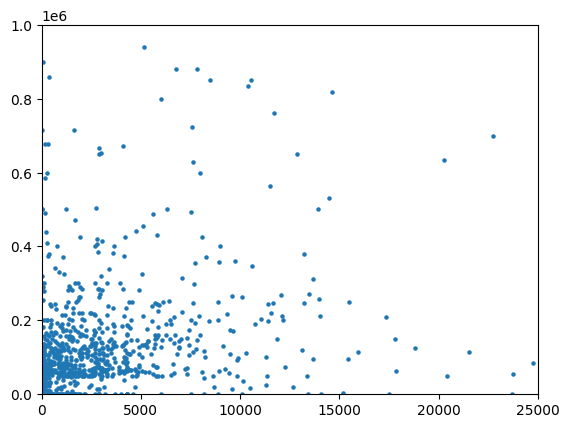

some values are not shown on the graph in order to see more details where the bulk of the data is


In [22]:
plt.scatter(df['OUTAGE.DURATION'], df['CUSTOMERS.AFFECTED'], s=5)
plt.xlim(0, 25000)
plt.ylim(0, 1000000)
plt.show()
print('some values are not shown on the graph in order to see more details where the bulk of the data is')

In [23]:
df_hypothesis = df[['OUTAGE.DURATION', 'CUSTOMERS.AFFECTED']].dropna()
df_hypothesis

,OUTAGE.DURATION,CUSTOMERS.AFFECTED
OBS,,
1.0,3060,70000.0
3.0,3000,70000.0
4.0,2550,68200.0
5.0,1740,250000.0
6.0,1860,60000.0
...,...,...
1523.0,95,35000.0
1524.0,360,0.0
1525.0,1548,0.0


In [24]:
scipy.stats.pearsonr(df_hypothesis['OUTAGE.DURATION'], df_hypothesis['CUSTOMERS.AFFECTED'])
#p_value, correlation

PearsonRResult(statistic=0.2619155954835712, pvalue=5.03140871848003e-18)

In [25]:
df_copy = df_hypothesis.copy()
df_copy['CUSTOMERS.AFFECTED'] = np.random.permutation(df_copy['CUSTOMERS.AFFECTED'])
df_copy

,OUTAGE.DURATION,CUSTOMERS.AFFECTED
OBS,,
1.0,3060,268000.0
3.0,3000,722000.0
4.0,2550,0.0
5.0,1740,0.0
6.0,1860,50000.0
...,...,...
1523.0,95,95000.0
1524.0,360,219000.0
1525.0,1548,128050.0


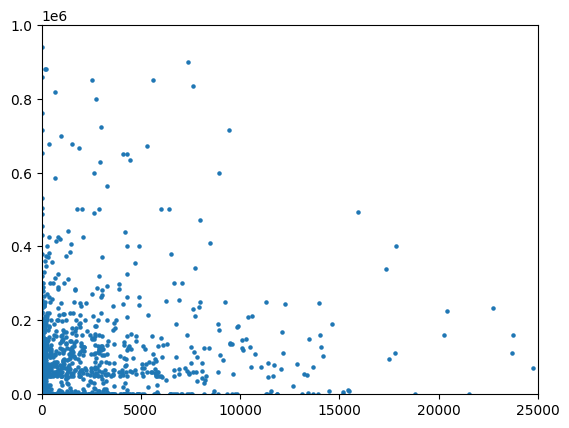

In [26]:
plt.scatter(df_copy['OUTAGE.DURATION'], df_copy['CUSTOMERS.AFFECTED'], s=5)
plt.xlim(0, 25000)
plt.ylim(0, 1000000)
plt.show()

In [27]:
df = df.apply(pd.to_numeric, errors='ignore')
numeric_df = df.select_dtypes(include='number')
numeric_df.columns

Index(['YEAR', 'MONTH', 'ANOMALY.LEVEL', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW',
       'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE', 'IND.PRICE',
       'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES',
       'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS',
       'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT',
       'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA',
       'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
       'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT',
       'PCT_WATER_INLAND'],
      dtype='object')

In [28]:
df_num_drop = numeric_df[['TOTAL.PRICE','OUTAGE.DURATION']].dropna()

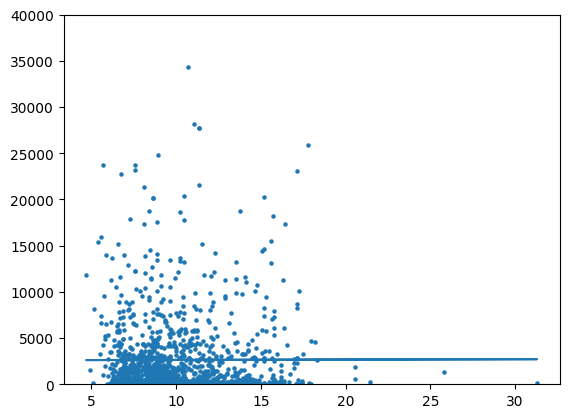

In [29]:
plt.scatter(df_num_drop['TOTAL.PRICE'], df_num_drop['OUTAGE.DURATION'], s=5)
a, b = np.polyfit(df_num_drop['TOTAL.PRICE'], df_num_drop['OUTAGE.DURATION'], 1)
plt.plot(df_num_drop['TOTAL.PRICE'], a*df_num_drop['TOTAL.PRICE']+b)
plt.ylim(0,40000)
plt.show()